In [ ]:
#pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu126
  Using cached https://download.pytorch.org/whl/cu126/torch-2.6.0%2Bcu126-cp311-cp311-win_amd64.whl.metadata (28 kB)
  Using cached https://download.pytorch.org/whl/cu126/torchvision-0.21.0%2Bcu126-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
  Using cached https://download.pytorch.org/whl/cu126/torchaudio-2.6.0%2Bcu126-cp311-cp311-win_amd64.whl.metadata (6.8 kB)
  Using cached https://download.pytorch.org/whl/sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Using cached https://download.pytorch.org/whl/mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached https://download.pytorch.org/whl/cu126/torch-2.6.0%2Bcu126-cp311-cp311-win_amd64.whl (2496.1 MB)
Using cached https://download.pytorch.org/whl/cu126/torchvision-0.21.0%2Bcu126-cp311-cp311-win_amd64.whl (6.1 MB)
Using cached https://download.pytorch.org/whl/cu126/torchaudio-2.6.0%2Bcu126-cp311-cp311-win_amd64.whl (4.2 MB)
   --------------------------------------

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn

print(torch.cuda.is_available())

True


In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

In [5]:
trainset = torchvision.datasets.MNIST('mnist',
                                      train = True,
                                      download=True,
                                      transform=transform)

testset = torchvision.datasets.MNIST('mnist',
                                      train = False,
                                      download=True,
                                      transform=transform)

100.0%
100.0%
100.0%
100.0%


In [6]:
print(trainset.data.shape)

torch.Size([60000, 28, 28])


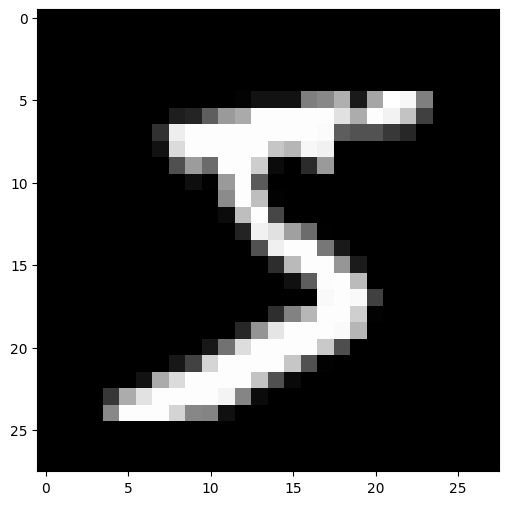

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def imgshow(title='',image = None , size = 6):
    w,h = image.shape[0],image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size*aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.show()

image = trainset.data[0].numpy()
imgshow('MNIST Sample',image)

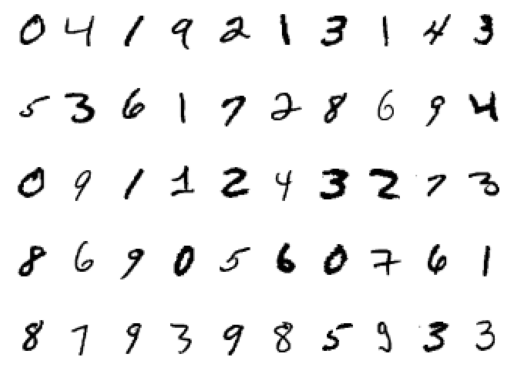

In [10]:
figure = plt.figure()
num_of_images = 50
for index in range(1,num_of_images +1):
    plt.subplot(5,10,index)
    plt.axis('off')
    plt.imshow(trainset.data[index].numpy(),cmap='gray_r')

In [12]:
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=0)
testloader = torch.utils.data.DataLoader(testset,
                                          batch_size=128,
                                          shuffle=False,
                                          num_workers=0)

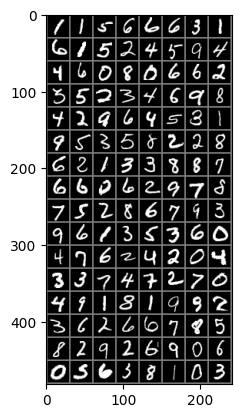

In [15]:
def imshow(img):
    img=img/2+0.5
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
dataiter = iter(trainloader)
images,labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [26]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,32,3)
        self.conv2 = nn.Conv2d(32,64,3)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*12*12,128)
        self.fc2 = nn.Linear(128,10)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,64*12*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [27]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),momentum=0.9)#base lr 0.001

In [30]:
import tqdm

epochs = 10
epoch_log = []
loss_log =[]
accuracy_log = []
for epoch in range(epochs):
    print(f"Starting Epoch :{epoch+1}")
    running_loss = 0
    for i,data in enumerate(trainloader,0):
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        if i%50 == 49:
            correct = 0
            total = 0
            with torch.no_grad():
                for data in trainloader:
                    images,labels = data
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = net(images)
                    _,predicted = torch.max(outputs.data,dim=1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            accuracy = 100 * correct/total
            epoch_num = epoch + 1
            actual_loss = running_loss/50
            print(f"Epoch : {epoch_num}, Mini-Batches Completed : {(i+1)}, Loss : {actual_loss:.3f}, Test Accuracy = {accuracy:0.3f}")
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    accuracy_log.append(accuracy)
print('Finished Training')

Starting Epoch :1
Epoch : 1, Mini-Batches Completed : 50, Loss : 2.157, Test Accuracy = 70.062
Epoch : 1, Mini-Batches Completed : 100, Loss : 4.000, Test Accuracy = 76.897
Epoch : 1, Mini-Batches Completed : 150, Loss : 5.150, Test Accuracy = 83.030
Epoch : 1, Mini-Batches Completed : 200, Loss : 5.798, Test Accuracy = 85.718
Epoch : 1, Mini-Batches Completed : 250, Loss : 6.285, Test Accuracy = 87.402
Epoch : 1, Mini-Batches Completed : 300, Loss : 6.710, Test Accuracy = 88.535
Epoch : 1, Mini-Batches Completed : 350, Loss : 7.103, Test Accuracy = 89.033
Epoch : 1, Mini-Batches Completed : 400, Loss : 7.493, Test Accuracy = 89.632
Epoch : 1, Mini-Batches Completed : 450, Loss : 7.847, Test Accuracy = 90.088
Starting Epoch :2
Epoch : 2, Mini-Batches Completed : 50, Loss : 0.314, Test Accuracy = 90.302
Epoch : 2, Mini-Batches Completed : 100, Loss : 0.640, Test Accuracy = 90.725
Epoch : 2, Mini-Batches Completed : 150, Loss : 0.950, Test Accuracy = 91.192
Epoch : 2, Mini-Batches Comple

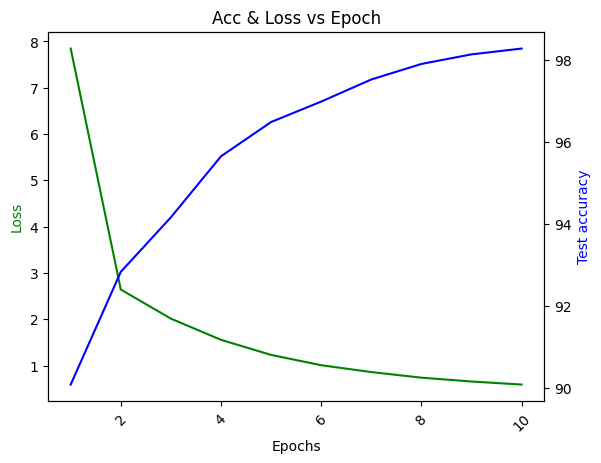

In [31]:
fig ,ax1 = plt.subplots()

plt.title("Acc & Loss vs Epoch")
plt.xticks(rotation=45)

ax2 = ax1.twinx()
ax1.plot(epoch_log,loss_log,'g-')
ax2.plot(epoch_log,accuracy_log,'b-')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss',color='g')
ax2.set_ylabel('Test accuracy',color='b')
plt.show()